# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

## Curve Fitting Switzerland COVID-19 Cases

In [3]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        two_weeks_ago = y[-15]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on', co.index[-1], '\t', current)
            print('\tConfirmed cases on', co.index[-8], '\t', lastweek)
            print('\tConfirmed cases on', co.index[-15], '\t', two_weeks_ago)
            ratio = current/lastweek
            two_weeks_ratio = lastweek / two_weeks_ago
            print('\tRatio (current/last):',round(ratio,2))
            print('\tRatio (lastweek/two_weeks_ago):',round(two_weeks_ratio,2))
            print('\tWeekly increase (last-current):',round( 100 * (ratio - 1), 1),'%')
            print('\tWeekly increase (2_weeks_ago-last):',round( 100 * (two_weeks_ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase (last-current):', dailypercentchange, '% per day')
            dailypercentchange_two_weeks = round( 100 * (pow(two_weeks_ratio, 1/7) - 1), 1)
            print('\tDaily increase (2_weeks_ago-last):', dailypercentchange_two_weeks, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time [last-current] (represents recent growth):',recentdbltime,'days')
            recentdbltime_two_weeks = round( 7 * np.log(2) / np.log(two_weeks_ratio), 1)
            print('\tDoubling Time [2_weeks_ago-last] (represents recent growth):',recentdbltime_two_weeks,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]

Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 14076
	Confirmed cases on 3/21/20 	 6575
	Confirmed cases on 3/14/20 	 1359
	Ratio (current/last): 2.14
	Ratio (lastweek/two_weeks_ago): 4.84
	Weekly increase (last-current): 114.1 %
	Weekly increase (2_weeks_ago-last): 383.8 %
	Daily increase (last-current): 11.5 % per day
	Daily increase (2_weeks_ago-last): 25.3 % per day
	Doubling Time [last-current] (represents recent growth): 6.4 days
	Doubling Time [2_weeks_ago-last] (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9987917389173533
	Doubling Time (during middle of growth):  5.09 (± 0.33 ) days

** Based on Exponential Fit **

	R^2: 0.9749942071660763
	Doubling Time (represents overall growth):  4.36 (± 0.59 ) days


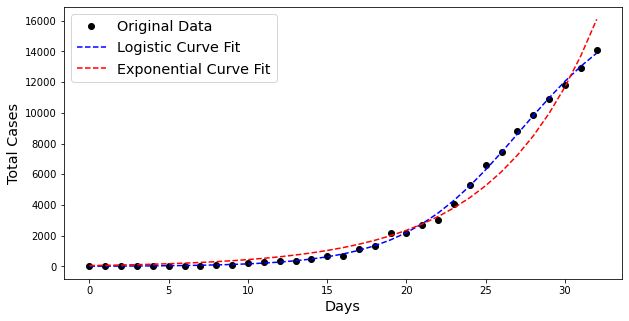

Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/28/20 	 57695
	Confirmed cases on 3/21/20 	 22213
	Confirmed cases on 3/14/20 	 4585
	Ratio (current/last): 2.6
	Ratio (lastweek/two_weeks_ago): 4.84
	Weekly increase (last-current): 159.7 %
	Weekly increase (2_weeks_ago-last): 384.5 %
	Daily increase (last-current): 14.6 % per day
	Daily increase (2_weeks_ago-last): 25.3 % per day
	Doubling Time [last-current] (represents recent growth): 5.1 days
	Doubling Time [2_weeks_ago-last] (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9979502193618535
	Doubling Time (during middle of growth):  6.33 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.9935179667217177
	Doubling Time (represents overall growth):  4.35 (± 0.19 ) days


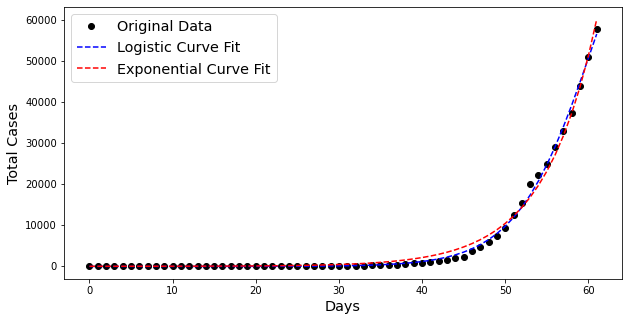

In [4]:
countries = ['Switzerland', 'Germany']
for c in countries:
    print(c)
    a = plotCases(df, 'Country/Region', c)